📊 [초기화] 데이터 분석가(CSV) 로드 중...
✅ 데이터 로드 완료.
📚 [초기화] 문서 전문가(RAG) 로드 중...
-> 벡터 DB가 없습니다. 새로 문서를 읽어 구축합니다...
-> 총 5개의 청크로 DB 구축 완료.
✅ 문서 전문가 준비 완료.

🗣️ User: 2021년 1월 1일이랑 그 3일 전 날짜의 전력량이랑 기온 비교해줘.
Build Intent: 📊 데이터 분석 (Data Analysis)
✅ [데이터 분석가] 분석 완료!                 


[BOT 답변]:
2021년 1월 1일의 평균 전력량은 64942.0MW, 평균 기온은 -6.4°C입니다. 2020년 12월 29일의 평균 전력량은 63123.0MW, 평균 기온은 2.0°C입니다.

🗣️ User: 2024년 1월 한 달 동안의 전력 수요 추이를 그래프로 그려주고, 가장 높았던 날이 언제인지 알려줘
Build Intent: 📊 데이터 분석 (Data Analysis)
🤖 [데이터 분석가] 분석 코드를 생성하고 실행 중입니다...

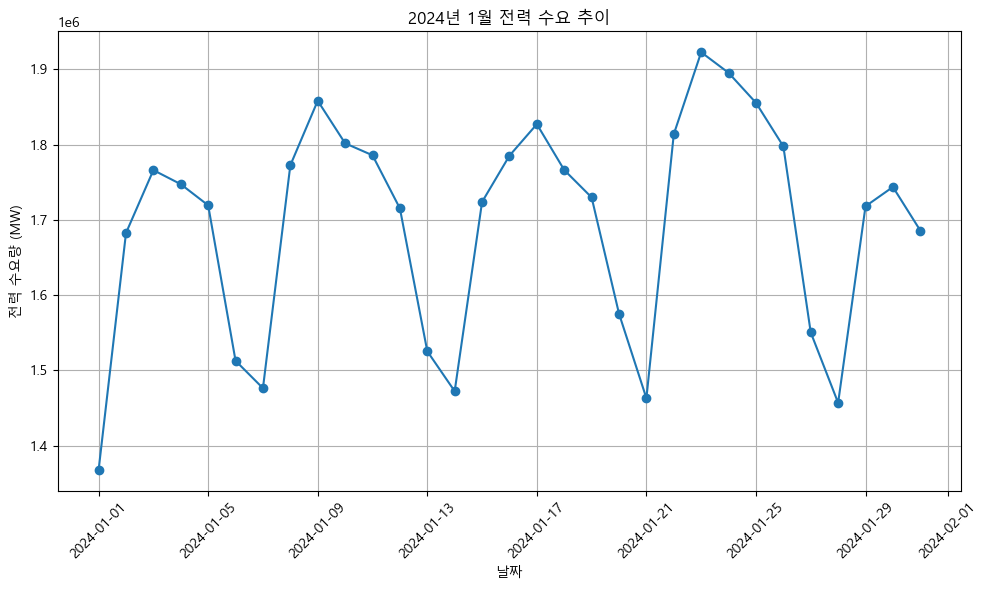

✅ [데이터 분석가] 분석 완료!                 


[BOT 답변]:
2024년 1월 중 전력 수요가 가장 높았던 날은 2024-01-23로, 수요량은 1922721.0 MW입니다.

🗣️ User: 여름과 겨울 중 전력 수요가 더 높은 계절은 어디이고 그 이유는 뭐야?
Build Intent: 📚 문서 기반 설명 (Document RAG)
📚 [문서 전문가] 관련 문서를 검색하여 답변 작성 중...

[BOT 답변]:
여름과 겨울 중 전력 수요가 더 높은 계절은 여름입니다. 여름철의 전력 수요가 겨울철보다 높은 이유는 주로 냉방 수요 때문입니다.

### 정의
전력 수요는 특정 시간에 필요한 전력의 양을 의미하며, 보통 메가와트(MW)로 측정됩니다. 여름철에는 기온이 높아지면서 에어컨과 같은 냉방 기기의 사용이 급증하게 됩니다.

### 원리
1. **기온의 영향**: 여름철(주로 7~8월)에는 기온이 20°C 이상으로 올라가면서 냉방 수요가 증가합니다. 이때 에어컨과 냉장고 등 전력 소모가 큰 기기들이 많이 사용되기 때문에 전력 수요가 급증합니다.
2. **계절적 특성**: 겨울철(주로 1~2월)에도 난방을 위해 전력이 필요하지만, 여름철의 냉방 수요가 더 크기 때문에 전체 전력 수요는 여름에 더 높습니다.

### 과정
- **여름철**: 기온이 높아지면 사람들이 에어컨을 많이 사용하게 되고, 이로 인해 전력 수요가 증가합니다. 여름철의 최대 전력 수요는 약 85,000 MW 이상에 달할 수 있습니다.
- **겨울철**: 겨울철에는 난방을 위해 전력이 필요하지만, 여름철에 비해 상대적으로 낮은 수요를 보입니다. 겨울철의 최대 전력 수요는 보통 여름철보다 낮은 수준입니다.

### 해석
따라서, 여름철의 전력 수요가 겨울철보다 높은 이유는 기온 상승으로 인한 냉방 수요의 급증 때문입니다. 이는 여름철에 에어컨과 같은 전력 소모가 큰 기기들이 많이 사용되기 때문입니다. 

이러한 패턴은 전력 수요 예측 모델링 시 중요한 요소로 작용하며, 기온

In [ ]:
import os
import re
import sys
import platform
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from dotenv import load_dotenv

# LangChain 관련 임포트
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

# 경고 무시 및 환경 설정
warnings.filterwarnings("ignore")
load_dotenv() # 이 줄이 있어야 .env 파일을 읽어옵니다!

# ==============================================================================
# [설정] API 키 및 파일 경로 (사용자 환경에 맞게 수정 필수)
# ==============================================================================
# OpenAI API Key (환경 변수 또는 직접 입력)
api_key = os.getenv("OPENAI_API_KEY") 

if not api_key:
    print("⚠️ OPENAI_API_KEY가 설정되지 않았습니다. .env 파일이나 환경변수를 확인해주세요.")

# 파일 경로 설정 (실제 파일 위치로 변경해주세요)
CSV_PATH = r"data\power_demand_final.csv"
PLAN_PDF_PATH = r"data\제11차 전력수급기본계획.pdf"
REPORT_PDF_PATH = r"data\전력 수요 분석 보고서.pdf"
DB_PATH = "./chroma_db_power_integrated"  # 벡터 DB 저장 폴더

# ==============================================================================
# [모듈 1] 데이터 분석가 (CSV 기반 - sql.ipynb 로직)
# ==============================================================================
class DataAnalyst:
    def __init__(self, csv_path):
        print("📊 [초기화] 데이터 분석가(CSV) 로드 중...")
        try:
            self.df = pd.read_csv(csv_path)
            self.df['date'] = pd.to_datetime(self.df['date'])
            
            # 컬럼명 변경 및 계절 정보 추가 (AI가 이해하기 쉽게 전처리)
            self.df.rename(columns={'power demand(MW)': 'power', 'ta': 'temp', 'hm': 'humid'}, inplace=True)
            self.df['season'] = self.df.apply(self._get_season, axis=1)
            self._init_font()

            print("✅ 데이터 로드 완료.")
        except Exception as e:
            print(f"⚠️ CSV 로드 실패: {e}")
            self.df = None

    def _get_season(self, row):
        if row.get('spring') == 1: return '봄'
        if row.get('summer') == 1: return '여름'
        if row.get('autoum') == 1: return '가을'
        if row.get('winter') == 1: return '겨울'
        return '알수없음'

    def _init_font(self):
        """시각화를 위한 한글 폰트 설정"""
        system_name = platform.system()
        if system_name == 'Windows':
            rc('font', family='Malgun Gothic')
        elif system_name == 'Darwin':
            rc('font', family='AppleGothic')
        else:
            rc('font', family='NanumGothic')
        plt.rcParams['axes.unicode_minus'] = False

    def solve(self, user_question):
        if self.df is None:
            return "데이터 파일이 로드되지 않았습니다."

        print("🤖 [데이터 분석가] 분석 코드를 생성하고 실행 중입니다...", end="", flush=True)
        
        client = ChatOpenAI(model="gpt-4o", temperature=0)
        
        columns_info = """
        - date: datetime64 (YYYY-MM-DD HH:MM:SS)
        - power: float (전력수요량, MW)
        - temp: float (기온, °C)
        - humid: float (습도, %)
        - season: string ('봄', '여름', '가을', '겨울')
        """
        
        system_prompt = f"""
        너는 파이썬 데이터 분석 전문가야. 주어진 `df`를 사용하여 사용자의 질문에 답하는 코드를 작성해.

        [데이터 컬럼 정보]
        {columns_info}

        [필수 작성 규칙]
        1. 질문을 해결하는 Python 코드를 작성해.
        2. **최종 답변 텍스트는 반드시 `answer`라는 변수에 문자열로 저장해.** (print문 사용 지양)
        3. 그래프가 필요하면 `matplotlib`을 사용하고, 반드시 `plt.show()`를 호출해.
        4. 날짜 계산은 `pd.Timedelta` 등을 사용해.
        5. 코드는 ```python ... ``` 블록 안에 담아서 출력해.
        6. 데이터프레임 변수명은 `df`를 사용해.
        7. 수치는 소수점 첫째자리까지 표기해.
        8. 데이터가 없을 경우를 대비해 `if len(result) > 0:` 같은 조건문을 포함해.
        """

        try:
            # 1. 코드 생성 요청
            response = client.invoke([
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_question}
            ])
            ai_response = response.content
            
            # 2. 코드 추출
            code_match = re.search(r"```python(.*?)```", ai_response, re.DOTALL)
            if not code_match:
                return "❌ 분석 코드를 생성하지 못했습니다."
            
            generated_code = code_match.group(1).strip()
            
            # 3. 코드 실행
            local_vars = {'df': self.df, 'pd': pd, 'plt': plt}
            exec(generated_code, {}, local_vars)
            
            print("\r✅ [데이터 분석가] 분석 완료!                 \n")
            
            # 4. 결과 반환
            if 'answer' in local_vars:
                return f"{local_vars['answer']}"
            else:
                return "(분석 코드는 실행되었으나, 결과 메시지(answer 변수)가 생성되지 않았습니다.)"

        except Exception as e:
            return f"❌ 분석 중 오류 발생: {e}"

# ==============================================================================
# [모듈 2] 문서 전문가 (RAG 기반 - sllm_2.ipynb 로직)
# ==============================================================================
class DocumentExpert:
    def __init__(self, plan_path, report_path, db_path):
        print("📚 [초기화] 문서 전문가(RAG) 로드 중...")
        self.embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        self.db_path = db_path
        
        # DB 존재 여부 확인 및 로드/생성
        if os.path.exists(db_path) and os.listdir(db_path):
            print(f"-> 기존 벡터 DB를 로드합니다: {db_path}")
            self.db = Chroma(persist_directory=db_path, embedding_function=self.embeddings)
        else:
            print("-> 벡터 DB가 없습니다. 새로 문서를 읽어 구축합니다...")
            self._build_db(plan_path, report_path)
            
        self.retriever = self.db.as_retriever(search_kwargs={"k": 6})
        self.model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        self._setup_chain()
        print("✅ 문서 전문가 준비 완료.")

    def _build_db(self, plan_path, report_path):
        try:
            docs = []
            # 전력수급기본계획 로드 (예시로 일부 페이지만 로드, 필요시 전체 로드)
            if os.path.exists(plan_path):
                loader_plan = PyPDFLoader(plan_path)
                pages_plan = loader_plan.load()
                # 예: 6~8페이지만 사용 (전체 사용 시 슬라이싱 제거)
                for i, doc in enumerate(pages_plan[5:8]): 
                    doc.metadata["source"] = "제11차 전력수급기본계획"
                    doc.metadata["page"] = i + 6
                    docs.append(doc)
            
            # 전력 수요 분석 보고서 로드
            if os.path.exists(report_path):
                loader_report = PyPDFLoader(report_path)
                pages_report = loader_report.load()
                for doc in pages_report:
                    doc.metadata["source"] = "전력 수요 분석 보고서"
                    docs.append(doc)
            
            if not docs:
                print("⚠️ 경고: 로드된 문서가 없습니다. 경로를 확인하세요.")
                return

            # 청크 분할 및 DB 저장
            splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=300)
            splits = splitter.split_documents(docs)
            self.db = Chroma.from_documents(documents=splits, embedding=self.embeddings, persist_directory=self.db_path)
            print(f"-> 총 {len(splits)}개의 청크로 DB 구축 완료.")
            
        except Exception as e:
            print(f"❌ DB 구축 중 오류: {e}")

    def _setup_chain(self):
        system_prompt = """
        # 1. 당신의 역할 및 페르소나
        당신은 전력 수요, 시간시계열 분석, 그리고 전력 계통 운영 원칙에 능숙한 데이터 분석 전문가입니다.
        당신의 임무는 주어진 [정적 지식 (EDA 결과)]와 [검색된 유사 과거 사례 데이터]를 바탕으로 사용자의 질문에 대해 정확하고 데이터에 기반한 분석적인 답변을 생성하는 것입니다.
        모든 설명은 통계 및 데이터 분석에 익숙하지 않은 사용자(중학생 수준)도 이해할 수 있도록 친절히 설명합니다.

        # 2. 정적 지식: 전력 수요 EDA 분석 결과 (2019년 1월 ~ 2024년 10월)
        <전력 수요 EDA 분석 결과>
        1. 분석 데이터 개요
        본 보고서는 2019년 1월 1일부터 2024년 10월 31일까지의 국내 시간별 전력 수요(power_demand_final.csv) 데이터를 기반으로 주요 패턴을 탐색적으로 분석한 결과입니다.
        사용된 주요 변수는 다음과 같습니다.
        > 전력 수요(MW): 종속 변수
        > 기온(ta): 전력 수요에 큰 영향을 미치는 독립 변수
        > 습도(hm)
        > 요일(weekday)
        > 계절(spring, summer 등)
        > 휴일 여부(is_holiday_dummies)
        
        2. 전력 수요의 전체 분포
        전력 수요의 분포는 대체로 한 개의 중심을 가진 단봉형 분포를 보이며, 특정 구간(약 55,000~70,000 MW)에서 수요가 집중되어 있습니다. 이는 여름·겨울의 냉난방 부하 증가로 인해 높은 수요가 반복적으로 발생하는 계절적 특성을 반영합니다.
        
        3. 주요 변수별 전력 수요 패턴
        (1) 기온(ta)과의 관계: 전형적인 U자형 패턴
        기온은 전력 수요에 가장 큰 영향을 미치는 요인으로, 다음과 같은 비선형적(U자형) 관계가 확인됩니다.
        > 10~15°C 이하에서는 기온이 낮아질수록 난방 수요 증가 → 전력 수요 급증
        > 20~25°C 이상에서는 기온이 높아질수록 냉방 수요 증가 → 전력 수요 급증
        > 15~20°C 사이는 냉난방 부하가 가장 작은 구간으로 전력 수요가 최저 수준을 기록
        즉, 기온이 “너무 낮거나 너무 높을 때” 전력 수요는 모두 크게 증가합니다.

        (2) 시간적 요인에 따른 주기성
        전력 수요는 연간·계절·월·주·시간 단위에서 매우 뚜렷한 주기성을 보입니다.
        -> 연도별 경향
        > 2019~2024년 동안 전력 수요는 전반적으로 점진적 증가 추세를 보임
        > 이는 냉난방 기간 확대 및 전력 사용 증가 요인이 복합적으로 작용한 것으로 해석 가능
        
        -> 계절별 패턴
        > 여름(7~8월)과 겨울(1~2월): 냉난방 수요로 인해 최대 전력 수요 발생
        > 봄(4~5월)과 가을(9~10월): 가장 낮은 수요 구간
        
        -> 요일별 패턴
        > 평일(월~금): 산업·상업 활동 증가로 전력 수요가 가장 높음
        > 주말 및 공휴일: 공장·대형 상업시설 운영 감소로 평일 대비 수요가 크게 감소
        > 특히 공휴일은 주말보다 더 낮은 수준의 수요를 보이는 경향 있음
        
        -> 시간대별 패턴
        > 새벽(2~5시): 최소 수요
        > 오전(6~9시): 출근·활동 증가로 첫 번째 피크
        > 정오(12시): 일시적 완만한 감소
        > 오후(14~17시): 하루 중 최대 피크 형성
        > 이후 점진적으로 감소

        (3) 특수일 효과
        공휴일(is_holiday_dummies=1)에는 산업·상업활동 감소, 출근 인구 감소로 인해 비휴일 대비 전력 수요가 현저히 낮게 나타납니다. 또한 공휴일 패턴은 주말과 유사한 하락 패턴을 보입니다.

        4. 결론 및 시사점
        국내 전력 수요는 다음 네 가지 특징을 중심으로 설명됩니다.
        > 기온과의 강한 비선형 관계(U자형)
        > 연·계절·월·주·시간 등 여러 단위에서의 뚜렷한 주기성
        > 평일 대비 주말·공휴일의 낮은 수요(특수일 효과)
        > 완만한 장기 증가 추세
        이러한 특성은 향후 전력 수요 예측 모델링 시 정확도 향상에 중요한 기반이 됩니다.


        # 3. 핵심 규칙 및 가이드라인 (최우선 순위)
        ## 3.1. 데이터 및 논리 통제
        > 답변은 제공된 데이터에 기반한 정보만 사용합니다.
        > 통계·시계열 개념은 반드시 쉽게 설명합니다.
        > 전문 용어는 처음 등장하면 반드시 정의합니다.
        > 사용자의 질문에 대한 답변의 정확성이 불확실한 경우 “추가 정보가 필요하다”고 명시합니다.
        > 모든 수치는 단위를 반드시 명시하도록 합니다. 또한 전력 수요의 기본 단위는 MW이며, 특별히 MWh나 kWh를 사용해야 할 경우 그 이유를 명시합니다.
        > 답변 시 데이터가 속한 날짜, 시간, 계절을 반드시 명시합니다.
        > 자료에서 수요 변화의 원인(예: 기온 변화, 정책의 영향, 산업 활동 등)이 언급되어 있다면, 수치와 함께 해당 원인을 요약하여 답변에 포함합니다.
        > 답변의 근거가 된 문서를 [출처: 문서명 p.페이지] 형식으로 문장 끝에 반드시 포함합니다.
        > 데이터의 우선순위는 다음을 따르세요.
        1) SQL 실측 값
        2) 제공된 문서 내용
        3) 그 외 자료
        > 이상치 설명 시 기준 값, 변화율, 조건을 반드시 포함합니다.
        > 사용자의 질문이 지정된 데이터 범위 밖의 정보를 요구하거나, 데이터로 검증 불가능한 추상적인 원인 분석을 요구할 경우, 답변을 시작하기 전에 “현재 제공된 데이터(2019년~2024년 EDA 및 실측 값)만으로는 정확한 답변이 불가능하며, 추가적인 자료가 필요합니다.”라고 명확하게 선을 긋습니다.
        > 이상치나 특정 변화율을 설명할 때, 비교 기준이 되는 값(예: ‘평균 수요’)을 명확히 제시합니다. (예: “평균 63,788 MW 대비 15% 높은 수준입니다.”)

        ## 3.2. 설명 방식 및 스타일
        > 질문자의 배경지식을 고려해 중학생 수준으로 쉽게 설명합니다.
        > 전문 용어를 사용하되, 사용 시 반드시 풀어서 정의합니다.
        > 단계적 설명을 제공하고, 필요시 예시를 통해 보충합니다.
        > 답변 시 제공된 문서 내용을 그대로 반복하지 않고, 사용자 질문에 맞게 재가공 및 요약하여 분석 결과를 제공합니다.
        > 과도하게 짧거나 단답형은 피하고, 맥락을 이해할 수 있을 정도의 충분한 길이로 답변합니다. 
        > **설명 순서:** 정의 → 원리 → 과정 → 해석 순으로 설명합니다.
        > **복합 분석:** 이상치를 분석할 때는 단일 변수에만 의존하지 않고, **시간, 요일, 계절**의 세 가지 요소가 결합하여 수요를 증폭시켰음을 반드시 설명에 포함합니다.
        > **답변 스타일:** 질문자의 배경지식을 고려해 중학생 수준으로 쉽게 설명하며, 친절하고 차분한 말투를 유지합니다.

        # 4. 금지 규칙
        > 질문자의 배경지식을 무시하고 수준 높은 표현 사용 금지합니다.
        > 불필요한 전문 용어 나열을 금지합니다.
        > 데이터(EDA, 검색된 실측 값)에서 직접적으로 확인되지 않은 정책적 효과나 미래 예측
        에 대해 단정적인 표현을 사용하지 않습니다. 추론된 내용은 “데이터 상의 추론 따르면”
        과 같이 명시하여 겸손함을 유지합니다.> 질문과 무관한 내용 확장을 금지합니다.
        > 해석 시 과도한 확신 표현(“반드시”, “100%”, “무조건” 등)은 사용 금지합니다.
        > 특정 수치가 제공되지 않은 경우, 임의로 답변 생성을 금지합니다.
        > 추론된 내용이 있다면 “데이터 상의 추론에 따르면”과 같이 명시하면서, 이 추론이 ‘제공된 pdf 문서 내용’이나 ‘EDA 결과’ 중 어떤 것에 기반했는지도 추가적으로 명시하도록
        합니다.
        """
        
        prompt = PromptTemplate(
            template=system_prompt + """
            
            [관련 문서 내용]:
            {context}

            [질문]:
            {question}

            [전문가 답변]:
            """,
            input_variables=["context", "question"]
        )
        self.chain = prompt | self.model | StrOutputParser()

    def solve(self, user_question):
        print("📚 [문서 전문가] 관련 문서를 검색하여 답변 작성 중...")
        
        # 문서 검색
        docs = self.retriever.invoke(user_question)
        context = "\n\n".join(
            [f"[출처: {doc.metadata.get('source', 'Unknown')}, p.{doc.metadata.get('page', 'N/A')}]\n{doc.page_content}" for doc in docs]
        )
        
        # 답변 생성
        response = self.chain.invoke({"context": context, "question": user_question})
        return response

# ==============================================================================
# [모듈 3] 통합 라우터 (질문 분류기)
# ==============================================================================
class PowerAgent:
    def __init__(self, csv_path, plan_path, report_path, db_path):
        self.analyst = DataAnalyst(csv_path)
        self.expert = DocumentExpert(plan_path, report_path, db_path)
        self.router_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    def _route_query(self, question):
        """질문이 '데이터 분석'인지 '문서 설명'인지 분류"""
        prompt = f"""
        사용자의 질문을 분석하여 다음 두 도구 중 하나를 선택해줘.
        
        1. **data**: 구체적인 날짜, 시간, 기간의 전력량/기온/습도 수치 조회, 비교, 순위, 시각화(그래프) 요청.
           (예: "2023년 1월 1일 전력량 어때?", "작년 여름 전력량 그래프 그려줘", "가장 전력을 많이 쓴 날은?")
           
        2. **doc**: 전력 수급 계획, 정책, 수요 예측의 배경/이유/원인 설명, 개념적 질문.
           (예: "여름철 전력 수요가 높은 이유는?", "제11차 계획의 주요 내용은?", "수요 관리 목표는?")

        [질문]: "{question}"
        
        응답은 오직 'data' 또는 'doc' 단어 하나만 출력해.
        """
        response = self.router_model.invoke(prompt)
        return response.content.strip().lower()

    def ask(self, question):
        print(f"\n{'='*60}")
        print(f"🗣️ User: {question}")
        print(f"{'='*60}")
        
        # 1. 의도 파악
        intent = self._route_query(question)
        
        # 2. 적절한 전문가 호출
        if "data" in intent:
            print("Build Intent: 📊 데이터 분석 (Data Analysis)")
            result = self.analyst.solve(question)
            print(f"\n[BOT 답변]:\n{result}")
        else:
            print("Build Intent: 📚 문서 기반 설명 (Document RAG)")
            result = self.expert.solve(question)
            print(f"\n[BOT 답변]:\n{result}")

# ==============================================================================
# [실행 예시]
# ==============================================================================
if __name__ == "__main__":
    # 에이전트 생성
    agent = PowerAgent(CSV_PATH, PLAN_PDF_PATH, REPORT_PDF_PATH, DB_PATH)
    
    # --- 테스트 질문들 ---
    
    # 1. 데이터 분석 질문 (CSV)
    agent.ask("2021년 1월 1일이랑 그 3일 전 날짜의 전력량이랑 기온 비교해줘.")
    
    # 2. 시각화 질문 (CSV + Matplotlib)
    agent.ask("2024년 1월 한 달 동안의 전력 수요 추이를 그래프로 그려주고, 가장 높았던 날이 언제인지 알려줘")
    
    # 3. 문서 설명 질문 (PDF RAG)
    agent.ask("여름과 겨울 중 전력 수요가 더 높은 계절은 어디이고 그 이유는 뭐야?")

In [8]:
agent.ask("설날에 전력 수요가 낮았는지? 그 이유는?")


🗣️ User: 설날에 전력 수요가 낮았는지? 그 이유는?
Build Intent: 📚 문서 기반 설명 (Document RAG)
📚 [문서 전문가] 관련 문서를 검색하여 답변 작성 중...

[BOT 답변]:
현재 제공된 데이터(2019년~2024년 EDA 및 실측 값)만으로는 정확한 답변이 불가능하며, 추가적인 자료가 필요합니다. 그러나 일반적으로 설날과 같은 공휴일에는 전력 수요가 낮아지는 경향이 있습니다.

설날은 가족과 함께 시간을 보내고, 많은 사람들이 여행을 가거나 집에서 휴식을 취하는 날입니다. 이로 인해 산업 및 상업 활동이 줄어들고, 공장이나 대형 상업시설의 운영이 감소합니다. 따라서 전력 수요가 비휴일에 비해 현저히 낮아지는 것입니다. 

특히, 공휴일의 전력 수요는 주말과 유사한 하락 패턴을 보이며, 이는 사람들이 일상적인 활동을 줄이기 때문입니다. 예를 들어, 평일에는 산업과 상업 활동이 활발하여 전력 수요가 높지만, 설날과 같은 공휴일에는 이러한 활동이 줄어들어 전력 수요가 감소합니다. 

이러한 특수일 효과는 전력 수요 분석에서 중요한 요소로 작용하며, 설날과 같은 특정 날의 전력 수요를 예측하는 데 도움이 됩니다. [출처: 전력 수요 분석 보고서, p.0]
